In [2]:
import requests
import re
import scipy
import spotipy
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from spotipy.oauth2 import SpotifyClientCredentials
from nltk.stem import WordNetLemmatizer 
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from nltk.corpus import stopwords

In [3]:
warnings.filterwarnings('ignore')

In [4]:
#authentication
id = '7b8a31dce5f24570b9fafea7b08cf5d6' #7b8a31dce5f24570b9fafea7b08cf5d6
secret = '234a689c485f49c1b23261e0df9a8e67' #234a689c485f49c1b23261e0df9a8e67

client_credentials_manager = SpotifyClientCredentials(client_id = id, client_secret = secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

# Tracks characteristics

artist name -> artist id -> artist albums -> artist tracks -> tracks characteristics

In [1273]:
#artist names
artists_df = pd.read_csv('artists.csv')
artists_list = artists_df.values.tolist()
artists_list = np.squeeze(artists_list, axis=(1,)).tolist()

In [1277]:
#artist id
artists_ids = []
for artist in artists_list:
    try:
        results = sp.search(q = artist, limit=3, type = 'artist')
        artist_id = results['artists']['items'][0]['id']
    except:
        artist_id = None
    finally:
        artists_ids.append(artist_id)

print(len(artists_ids)) 

344


In [1278]:
artists_df['id'] = artists_ids

In [1296]:
#artist albums
albums_count = []
albums_ids = []
for id in artists_df['id']:
    album_ids = [el['id'] for el in sp.artist_albums(id)['items']]
    albums_ids.append(album_ids)
    albums_count.append(len(album_ids))

In [1300]:
artists_df['albums_ids'] = albums_ids
artists_df['albums_count'] = albums_count

In [1340]:
#album tracks
for album_list in artists_df['albums_ids'][:2]:
    for album_id in album_list[:2]:
        try:
            album = sp.album_tracks(album_id)
            tracks_data = get_tracks_info(album)
            data.append(tracks_data)
        except:
            continue

        

In [1307]:
#sample example
results = sp.search(q='monster', limit=10, type = 'track')

In [1312]:
def get_tracks_info(results): #input as dict from sp.search

    danceability = []
    energy = []
    key = []
    loudness = []
    speechiness = []
    acousticness = []
    instrumentalness = []
    liveness = []
    valence = []
    tempo = []
    ids = []
    artists = []
    song_names = []

    for i in results['items']:
        for x in sp.audio_features(i['id']):
            danceability.append(x['danceability'])
            energy.append(x['energy'])
            key.append(x['key'])
            loudness.append(x['loudness'])
            speechiness.append(x['speechiness'])
            acousticness.append(x['acousticness'])
            instrumentalness.append(x['instrumentalness'])
            liveness.append(x['liveness'])
            valence.append(x['valence'])
            tempo.append(x['tempo'])
            ids.append(i['id'])
        artists.append(i['artists'][0]['name'])
        song_names.append(i['name'])

    tracks_info = pd.DataFrame({
    'artist': artists,
    'song_name': song_names,
    'danceability':danceability,
    'energy':energy,
    'key':key,
    'loudness':loudness,
    'speechiness':speechiness,
    'acousticness':acousticness,
    'instrumentalness':instrumentalness,
    'liveness':liveness,
    'valence':valence,
    'tempo':tempo,
    },
    index = ids)
    
    tracks_info.index.name = 'track_id'

    return tracks_info

In [1181]:
tracks_df = get_tracks_info(results)

In [8]:
tracks_df = pd.read_csv('cb_data.csv', index_col = ['track_id'])
tracks_df.drop(['Unnamed: 0', 'genre1', 'genre2', 'cluster_means', 'clust', 'genre', 'p'], axis = 1, inplace = True)

In [9]:
id2track = tracks_df.iloc[:, :2]
id2track['full_name'] = id2track['artist'] + ' ' + id2track['song_name']

# Lyrics

In [1183]:
#lyrics for single artist-song pair
def get_lyrics(artist, song_name):
    artist_name = str(artist.replace(' ','-')) if ' ' in artist else str(artist)
    song_name = str(song_name.replace(' ','-')) if ' ' in song_name else str(song_name)
    page = requests.get('https://genius.com/'+ artist_name + '-' + song_name + '-' + 'lyrics')
    html = BeautifulSoup(page.text, 'html.parser')
    lyrics = html.find("div", class_="Lyrics__Container-sc-1ynbvzw-6 jYfhrf")
    return lyrics

In [1184]:
#lyrics for all ids
lyrics_total = []
for i in range(len(tracks_df)):
    try:
        track = get_lyrics(tracks_df['artist'][i], tracks_df['song_name'][i]).get_text()
    except:
        track = None
    lyrics_total.append(track)

In [1]:
tracks_df

NameError: name 'tracks_df' is not defined

### Text cleaning

In [3]:
#removing [text]
def remove_brackets(lyrics_total):
    lyrics_cleaned = []
    pattern = r'\[.*?\]'
    for text in lyrics_total:
        try:
            text_new = re.sub(pattern, '', text)
        except:
            text_new = 'None'
        lyrics_cleaned.append(text_new)

    return lyrics_cleaned


NameError: name 'tracks_df' is not defined

In [1187]:
lyrics_no_brackets = remove_brackets(lyrics_total)

In [1188]:
#separating new paragraphs 
def separate_paragraphs(lyrics_no_brackets): # string format
    lyrics_separate = []
    for track in lyrics_no_brackets:
        track_cleaned = []
        for word in track.split():
            word_new = ' '.join(re.split('(?<=[a-z])(?=[A-Z])', word))
            track_cleaned.append(word_new)

        lyrics = ' '.join(track_cleaned)
        lyrics_separate.append(lyrics)
    return lyrics_separate

In [1189]:
lyrics_separate = separate_paragraphs(lyrics_no_brackets)

In [1190]:
#removing punctiations + lemmatization + lowercasing
lemmatizer = WordNetLemmatizer()
def process_lyrics(lyrics_separate):
    lyrics_cleaned = []
    for text in lyrics_separate:
        text = re.sub('[^a-zA-Z0-9]+\s*', ' ', text)
        text = text.lower()
        text = [lemmatizer.lemmatize(word) for word in text.split()]
        text = ' '.join(text)
        lyrics_cleaned.append(text)

    return lyrics_cleaned

In [1191]:
lyrics_cleaned = process_lyrics(lyrics_separate)

In [1192]:
#stopwords 
stopwords_list = stopwords.words('english')
def remove_stopwords(lyrics_cleaned):
    lyrics_list = []
    for text in lyrics_cleaned:
        text_no_stops = [word for word in text.split() if word not in stopwords_list]
        text = ' '.join(text_no_stops)
        lyrics_list.append(text)
    
    return lyrics_list

In [1193]:
lyrics_cleaned = remove_stopwords(lyrics_cleaned)

# Recommendations by Lyrics

In [1194]:
#from sklearn.feature_extraction.text import CountVectorizer
#vect = CountVectorizer(lowercase = True, analyzer = 'word', stop_words = 'english')
#matrix = pd.DataFrame(matrix.todense(), columns=vect.get_feature_names())

In [1195]:
#list(set(em.split()) & set(west.split()))

<AxesSubplot:>

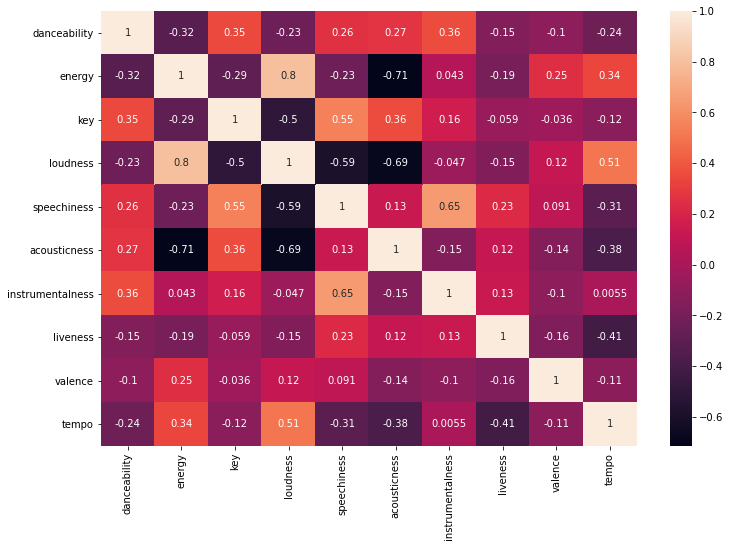

In [1196]:
plt.figure(figsize = (12, 8))
sns.heatmap(tracks_df.iloc[:, 2:].corr(), annot = True)

### Gensim, doc2vec model

In [1197]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk

In [1198]:
train_corpus = [TaggedDocument(words=nltk.word_tokenize(text.lower()), tags=[str(i)]) for i, text in list(enumerate(lyrics_cleaned))]

In [1199]:
model = Doc2Vec(vector_size = 50, min_count = 2, epochs = 10, dm = 0, workers = 3)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [1200]:
vectors = []
for i in range(len(train_corpus)):
    vector = model.infer_vector(train_corpus[i][0])
    vectors.append(vector)

In [1201]:
vectors_df = pd.DataFrame(data = vectors, index = tracks_df.index)

In [1202]:
vector_matrix = sparse.csr_matrix(np.array(vectors_df))
similarities = cosine_similarity(vector_matrix)
similarities_df = pd.DataFrame(similarities, index = tracks_df.index, columns = tracks_df.index)
#remove none texts
id2text = dict(zip(tracks_df.index, lyrics_cleaned))
#right ids
is_lyrics = [id for id in id2text.keys() if id2text[id] != 'none']
#only tracks with parsed lyrics
similarities_df = similarities_df.loc[is_lyrics, is_lyrics]
#avoiding self-recommendation
similarities_df.values[[np.arange(similarities_df.shape[0])]*2] = -1

In [1203]:
similarities_df.tail()

track_id,2UREu1Y8CO4jXkbvqAtP7g,1ZHYJ2Wwgxes4m8Ba88PeK,4GssB27iJeqmfGxS94Tfij,48RrDBpOSSl1aLVCalGl5C,1qAuIPMALdFtGv2Ymjy5l0,2ihCaVdNZmnHZWt0fvAM7B,2FUNBaa5DwItJtYEBgAblU,0SiywuOBRcynK0uKGWdCnn,2Xaw1RrXP3mdooKWysuRJ8,4F7A0DXBrmUAkp32uenhZt,7GbUWl6qLW1gdngbEV2WDJ,7u9BIFBgxuqntGW7wO5lMs
track_id,,,,,,,,,,,,
0SiywuOBRcynK0uKGWdCnn,0.980988,0.970473,0.982582,0.982193,0.971815,0.952559,0.982454,-1.000000,0.932066,0.982153,0.575429,0.979208
2Xaw1RrXP3mdooKWysuRJ8,0.929357,0.914065,0.928169,0.941726,0.916825,0.889676,0.939153,0.932066,-1.000000,0.933592,0.529605,0.932113
4F7A0DXBrmUAkp32uenhZt,0.990611,0.980869,0.990467,0.991123,0.975848,0.958970,0.993629,0.982153,0.933592,-1.000000,0.593497,0.992846
7GbUWl6qLW1gdngbEV2WDJ,0.570500,0.556008,0.583585,0.573172,0.593972,0.556279,0.586330,0.575429,0.529605,0.593497,-1.000000,0.592879
7u9BIFBgxuqntGW7wO5lMs,0.989506,0.976332,0.990720,0.989708,0.977027,0.960160,0.993058,0.979208,0.932113,0.992846,0.592879,-1.000000


In [1204]:
id2track.head(3)

,artist,song_name,full_name
track_id,,,
2UREu1Y8CO4jXkbvqAtP7g,Skillet,Monster,Skillet Monster
1ZHYJ2Wwgxes4m8Ba88PeK,Kanye West,Monster,Kanye West Monster
4GssB27iJeqmfGxS94Tfij,Falling In Reverse,Popular Monster,Falling In Reverse Popular Monster


In [1205]:
def get_recommendation_by_lyrics(track_full_name, n = 3): # <artist> <song_name>, number of recommendations
    try:
        track_id = id2track[id2track.full_name == track_full_name].index[0]
        recommendation_list = list(similarities_df.loc[track_id, :].sort_values(ascending = False)[:n].index)
        track_names = [f'{id2track.loc[rec][1]} by {id2track.loc[rec][0]}' for rec in recommendation_list]
        track_url_list = [f'https://open.spotify.com/track/{rec}' for rec in recommendation_list]
        return track_names, track_url_list

    except:
        return "Track is not found"

In [1206]:
get_recommendation_by_lyrics('Falling In Reverse Popular Monster')

(['monster by 21 Savage',
  'Demons and Monsters by 347aidan',
  'Party Monster by The Weeknd'],
 ['https://open.spotify.com/track/2FUNBaa5DwItJtYEBgAblU',
  'https://open.spotify.com/track/7u9BIFBgxuqntGW7wO5lMs',
  'https://open.spotify.com/track/4F7A0DXBrmUAkp32uenhZt'])

### Single prediction

class MusicGuru:
    def __init__(self, input_track):
        self.input_track = input_track

    def get_recommendation_by_lyrics(self, n):

    def delete_track_from_database(self, database_type):

    def get_recommendation_by_characteristics(....)

    def plot_track_characteristics(...)

    def plot_artist_comparison(...)

In [1228]:
tracks_df.head()

,artist,song_name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
track_id,,,,,,,,,,,,
2UREu1Y8CO4jXkbvqAtP7g,Skillet,Monster,0.640,0.957,8,-2.336,0.0741,0.04310,0.0000,0.0789,0.6920,134.992
1ZHYJ2Wwgxes4m8Ba88PeK,Kanye West,Monster,0.628,0.692,2,-5.640,0.2020,0.00244,0.0129,0.6680,0.0963,124.887
4GssB27iJeqmfGxS94Tfij,Falling In Reverse,Popular Monster,0.461,0.897,3,-3.982,0.0920,0.00821,0.0000,0.0965,0.3580,165.107
0tyR7Bu9P086aWBFZ4QJoo,All Time Low,Monsters (feat. blackbear),0.369,0.845,0,-3.449,0.0611,0.04930,0.0000,0.4160,0.7820,78.532
48RrDBpOSSl1aLVCalGl5C,Eminem,The Monster,0.781,0.853,1,-3.680,0.0715,0.05250,0.0000,0.1200,0.6240,110.049


In [1207]:
class MusicGuru:
    def __init__(self, input_track):
        self.input_track = input_track

    def get_recommendation_by_lyrics(self, n):
        input_artist = sp.track(self.input_track)['artists'][0]['name']
        input_name = sp.track(self.input_track)['name']
        input_features = sp.audio_features(self.input_track)
        d = {'artist': input_artist, 'song_name': input_name}
        d.update(input_features[0])
        track_data = pd.DataFrame([d], index = [self.input_track]).iloc[0, :13]

        #get lyrics
        try:
            lyrics = get_lyrics(track_data['artist'], track_data['song_name']).get_text()
        except:
            lyrics = None

         #if no lyrics found   
        if lyrics == None:
            return 'Unfortunately, we are unable to find any lyrics. Try another track!'
        
        global tracks_df
        global id2track
        global vectors_df
        global vector_matrix #eliminate
        global similarities_df
        global is_lyrics #eliminate

        if self.input_track in tracks_df.index:
            track_full_name = id2track.loc[self.input_track]['full_name']
            track_id = id2track[id2track.full_name == track_full_name].index[0]
            recommendation_list = list(similarities_df.loc[track_id, :].sort_values(ascending = False)[:n].index)
            track_names = [f'{id2track.loc[rec][1]} by {id2track.loc[rec][0]}' for rec in recommendation_list]
            track_url_list = [f'https://open.spotify.com/track/{rec}' for rec in recommendation_list]
            return track_names, track_url_list

        else:   
            #remove brackets
            track_no_brackets = remove_brackets([lyrics])

            #separate paragraphs
            track_separate = separate_paragraphs(track_no_brackets)

            #cleaning
            track_processed = process_lyrics(track_separate)

            #stopwords
            track_no_stopwords = remove_stopwords(track_processed)

            #vectorizing the input
            track_vector = model.infer_vector(track_no_stopwords)
            track_vector = pd.DataFrame(data = [track_vector], index = [self.input_track])

            #return track_data, track_vector # data for track_df, vector for the rest

            
           #globals

            #updating dataframes
            tracks_df = tracks_df.append(track_data)
            tracks_df.drop('mode', inplace = True, axis = 1)
            id2track.loc[tracks_df.index[-1], 'artist'] = tracks_df.loc[tracks_df.index[-1], 'artist'] 
            id2track.loc[tracks_df.index[-1], 'song_name'] = tracks_df.loc[tracks_df.index[-1], 'song_name'] 
            id2track.loc[tracks_df.index[-1], 'full_name'] = id2track.loc[id2track.index[-1], 'artist'] + ' ' + id2track.loc[id2track.index[-1], 'song_name']

            vectors_df = vectors_df.append(track_vector)

            is_lyrics.append(self.input_track)

            #cosine
            track_cosine = cosine_similarity(vector_matrix, track_vector)
            track_cosine = np.append(track_cosine, -1)
            track_cosine = pd.DataFrame(track_cosine, index = id2track.index).transpose()
            track_cosine = track_cosine[is_lyrics]
            track_cosine.index = [self.input_track]
            track_cosine = track_cosine[track_cosine.columns.unique()]

            #updating similarity data
            similarities_df[self.input_track] = track_cosine.transpose()
            similarities_df = similarities_df.append(track_cosine)

            #updating matrix for further recs
            vector_matrix = sparse.csr_matrix(np.array(vectors_df))

            #return similarities_df.shape, len(is_lyrics)

            try:
                track_full_name = id2track.loc[self.input_track]['full_name']
                track_id = id2track[id2track.full_name == track_full_name].index[0]
                recommendation_list = list(similarities_df.loc[track_id, :].sort_values(ascending = False)[:n].index)
                track_names = [f'{id2track.loc[rec][1]} by {id2track.loc[rec][0]}' for rec in recommendation_list]
                track_url_list = [f'https://open.spotify.com/track/{rec}' for rec in recommendation_list]
                return track_names, track_url_list

            except:
                return "Track is not found"
        

In [1208]:
#no lyrics 0tyR7Bu9P086aWBFZ4QJoo
#already in DB 2UREu1Y8CO4jXkbvqAtP7g
#new 0qo1JukfClmpHnUOJxpFXi
guru = MusicGuru('2UREu1Y8CO4jXkbvqAtP7g')
guru.get_recommendation_by_lyrics(3)

(['monster by 21 Savage',
  'Party Monster by The Weeknd',
  'Popular Monster by Falling In Reverse'],
 ['https://open.spotify.com/track/2FUNBaa5DwItJtYEBgAblU',
  'https://open.spotify.com/track/4F7A0DXBrmUAkp32uenhZt',
  'https://open.spotify.com/track/4GssB27iJeqmfGxS94Tfij'])

In [1211]:
#new 0qo1JukfClmpHnUOJxpFXi
guru = MusicGuru('0qo1JukfClmpHnUOJxpFXi')
guru.get_recommendation_by_lyrics(3)

(['Monster by Imagine Dragons',
  'The Monster by Eminem',
  'Monster by Kanye West'],
 ['https://open.spotify.com/track/2Xaw1RrXP3mdooKWysuRJ8',
  'https://open.spotify.com/track/48RrDBpOSSl1aLVCalGl5C',
  'https://open.spotify.com/track/1ZHYJ2Wwgxes4m8Ba88PeK'])

In [1229]:
names = ['Monster by Imagine Dragons',
  'The Monster by Eminem',
  'Monster by Kanye West']

ids = ['2Xaw1RrXP3mdooKWysuRJ8',
  '48RrDBpOSSl1aLVCalGl5C',
  '1ZHYJ2Wwgxes4m8Ba88PeK']

In [1232]:
get_lyrics('Eminem', 'The Monster').get_text()

"[Intro: Rihanna]I'm friends with the monster that's under my bedGet along with the voices inside of my headYou're tryin' to save me, stop holdin' your breathAnd you think I'm crazy, yeah, you think I'm crazy[Verse 1: Eminem]I wanted the fame but not the cover of NewsweekOh well, guess beggars can't be chooseyWanted to receive attention for my musicWanted to be left alone in public, excuse meFor wantin' my cake, and eat it too, and wantin' it both waysFame made me a balloon 'cause my ego inflatedWhen I blew, see, but it was confusing'Cause all I wanted to do's be the Bruce Lee of loose leafAbused ink, used it as a tool when I blew steamWhoo! Hit the lottery, ooh-wee!But with what I gave up to get it was bittersweetIt was like winnin' a used minkIronic 'cause I think I'm gettin' so huge I need a shrinkI'm beginnin' to lose sleep: one sheep, two sheepGoin' coo-coo and kooky as Kool KeithBut I'm actually weirder than you think, 'cause I'm—"

In [1213]:
#no lyrics 0tyR7Bu9P086aWBFZ4QJoo
guru = MusicGuru('0tyR7Bu9P086aWBFZ4QJoo')
guru.get_recommendation_by_lyrics(3)

'Unfortunately, we are unable to find any lyrics. Try another track!'

In [1070]:
def delete_track_from_database(input_track): #id format
    global tracks_df
    global id2track
    global vectors_df
    global vector_matrix
    global similarities_df
    global is_lyrics
    try:
        tracks_df = tracks_df[tracks_df.index != input_track] #
        id2track = id2track[id2track.index != input_track] #
        vectors_df = vectors_df[vectors_df.index != input_track]
        vector_matrix = sparse.csr_matrix(np.array(vectors_df))
        similarities_df = similarities_df[similarities_df.index != input_track]
        similarities_df.drop(input_track, inplace = True, axis = 1)
        is_lyrics.pop()
        print('Track has been deleted successfully.')
    
    except:
        print('Already deleted.')

# Recommendations by characteristics

# Visualization

### Visualization of track characteristics

### t-SNE for artists comparison